# Simulate multi-qubit circuits 
**Simulating the dynamics of a multi-qubit circuit with and without noise**

The Q-CTRL Python package enables you to simulate the evolution of isolated quantum systems (see the [Simulate quantum dynamics](https://docs.q-ctrl.com/boulder-opal/user-guides/simulate-quantum-dynamics) user guide) and the evolution of systems that are interacting with their environment (see the [Simulate open systems dynamics](https://docs.q-ctrl.com/boulder-opal/user-guides/simulate-open-system-dynamics) user guide). These user guides discussed simulation of single qubit systems and a 1-D quantum chain. In this notebook, we will show how the same simulation features can be used to simulate a multi-qubit quantum circuit using the cross-resonance Hamiltonian model.

## Imports and initialization

All usage of the Q-CTRL Python package begins by importing the `qctrl` package and starting a session.

In [1]:
# Essential imports
from random import sample as random_sample
import jsonpickle
import matplotlib.pyplot as plt
import numpy as np

# Predefined pulses and Q-CTRL plot style
from qctrlopencontrols import new_corpse_control
from qctrlvisualizer import get_qctrl_style, plot_controls

plt.style.use(get_qctrl_style())

# Starting a session with the API
from qctrl import Qctrl

qctrl = Qctrl()

## Worked example: Simulating the three qubit GHZ state preparation circuit

Consider a three qubit system which has a single qubit drive on each qubit and a two-qubit cross-resonance drive between each consecutive pair (1-2 and 2-3) of qubits. The Hamiltonian for the single qubit drive on qubit $i$ is given by
$$
H^{\rm{S}}_{i}(t) = \frac{1}{2} \Omega_{i}(t) \sigma^{-}_{i} + \frac{1}{2} \Omega_{i}^{*}(t)\sigma^{+}_{i}
$$

and the Hamiltonian of the two-qubit cross-resonance drive between qubit $i$ and $j$ is given by

$$
H^{\rm{CR}}_{ij}(t) = \frac{1}{2} \left( \Gamma_{ij}(t) \sigma^{-}_{i} + \Gamma_{ij}^{*}(t)\sigma^{+}_{i} \right)  \otimes \sigma^{z}_j
$$

where $\sigma^x$, $\sigma^y$ and $\sigma^z$ are the Pauli matrices, $\sigma^{\pm} = (\sigma^x \mp i \sigma^y)/2$ are the Pauli ladder operators, and $\Omega_i$ and $\Gamma_{ij}$ are complex Rabi rates that control the single qubit evolution and the two-qubit evolution respectively. The total system Hamiltonian is then

$$
H^{\rm{total}}(t) = \sum_{i=1}^3 H^{\rm{S}}_{i}(t) + \sum_{i=1,2} H^{\rm{CR}}_{i,i+1}(t) +  H^{\rm{CR}}_{i+1,i}(t)
$$
This cross-resonance Hamiltonian model approximates the behavior of many commercial quantum computing devices as described in a review by [Krantz et al.](http://aip.scitation.org/doi/10.1063/1.5089550)

We want to use this Hamiltonian to implement a circuit that prepares the Greenberger–Horne–Zeilinger (GHZ) state
$$
\left| \rm{GHZ} \right> = \frac{\left( \left| 000 \right> + \left| 111 \right> \right)}{\sqrt{2}}
$$
We can use the standard three-qubit GHZ circuit —which contains a Hadamard gate on the first qubit followed by two CNOT gates between the first and the second qubit, and the second and the third qubit— to prepare this state.

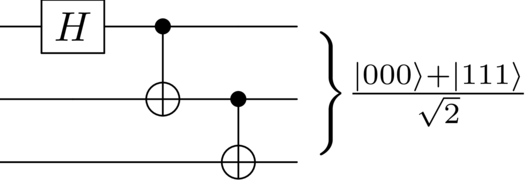

### From gates to pulses

To use the Hamiltonian to implement the circuit, we first need to figure out how to drive the controls $\Omega_i$ and $\Gamma_{ij}$ to implement the Hadamard and CNOT gates required for the circuit. These gates can be created by a combination of pulses that implement certain basic controls, such as rotating the qubit along one of the axes of the Bloch sphere. We will use the notation $Y_\theta = Y(\theta) = \exp (-i\frac{\theta}{2}\sigma^y)$ to denote a rotation of angle $\theta$ along the Y-axis (and the same notation for rotations along the X and the Z axis).

Ignoring global phases, the Hadamard gate can be constructed with two rotations
$$
H = Y_{\pi/2} Z_{\pi}\ 
$$
and the CNOT gate can be obtained by combining two single qubit rotations and one two-qubit rotation
$$
\rm{CNOT}^{ij} = Z^i_{\pi/2} X^j_{\pi/2} \rm{XZ}^{ji}_{-\pi/2} \ .
$$

### Creating the pulses 

We need five different pulses: three pulses that rotate a qubit by $\pi/2$ radians along the $X$, the $Y$ and the $Z$-axis, a pulse that rotates a qubit by $\pi$ radians along the $Z$-axis, and a pulse that rotates a two-qubit channel by $-\pi/2$ radians. We will also assume that the controls $\Omega_i(t)$ can be selected between the values $[-\Omega_{\rm max}, \Omega_{\rm max}]$ and controls $\Gamma_{ij}(t)$ can be selected between $[-\Gamma_{\rm max}, \Gamma_{\rm max}]$.

Let us generate these different pulses using the [CORPSE](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols/new_corpse_control.html) pulse provided by the Q-CTRL Open Controls package.

In [2]:
# Standard matrices
identity = np.identity(2, dtype=np.complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)
sigma_p = 0.5 * (sigma_x - 1j * sigma_y)
sigma_m = 0.5 * (sigma_x + 1j * sigma_y)

# Multi-qubit operators
def kron(*args, start=[1]):
    result = start
    for term in args:
        result = np.kron(result, term)
    return result


# Define control parameters
omega_max = 2 * np.pi * 1e6  # Hz
gamma_max = np.pi * 1e6  # Hz

# Define the initial state
initial_state = np.zeros((2 ** 3, 1), dtype=np.complex)
initial_state[0] = 1

# Get predefined X90, Y90 and CR pulses. The `new_corpse_control` function creates a pulse with three segments.
dt = 3
X90_pulse = new_corpse_control(
    rabi_rotation=np.pi / 2, maximum_rabi_rate=omega_max, azimuthal_angle=0, name="X90"
)
Y90_pulse = new_corpse_control(
    rabi_rotation=np.pi / 2,
    maximum_rabi_rate=omega_max,
    azimuthal_angle=np.pi / 2,
    name="Y90",
)
CR90m_pulse = new_corpse_control(
    rabi_rotation=np.pi / 2,
    maximum_rabi_rate=gamma_max,
    azimuthal_angle=np.pi,
    name="CR90m",
)

# Get the amplitude of these pulses.
X90_amplitude = X90_pulse.amplitude_x + 1j * X90_pulse.amplitude_y
Y90_amplitude = Y90_pulse.amplitude_x + 1j * Y90_pulse.amplitude_y
CR90m_amplitude = CR90m_pulse.amplitude_x + 1j * CR90m_pulse.amplitude_y

### Creating the schedule 

We have created pulses that can do $X_{\pi/2}$, $Y_{\pi/2}$ and $\rm{XZ}_{-\pi/2}$ rotations, but there are no terms in the Hamiltonian to implement a rotation about the $Z$-axis. Nevertheless, the cross-resonance Hamiltonian can be used to achieve [_virtual_-$Z$ rotations](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.96.022330) by noting the following relationship between two pulses $\Omega(t)$ and $\Omega(t)e^{i \phi}$: if the first pulse implements the unitary $U$ using the cross-resonance Hamiltonian, then the unitary $U_\phi$ implemented by the second pulse is given by
$$
U_\phi = Z_\phi U Z_{-\phi}\ .
$$
Thus, to achieve a rotation of $\phi$ radians along the Z-axis, we should rotate all subsequent physical pulses by an angle $-\phi$. A quantum state prepared by circuits employing virtual-$Z$ rotations differs from the ideal quantum state by an overall unitary $\prod_i Z^i_{-\phi_i}$. However, this quantum state has same classical measurement results as the ideal quantum state when measured in the $Z$-basis. Hence, virtual $Z$-rotations do not change the populations in the computational basis.

We can now combine the pulses and virtual $Z$-rotations together to generate a _schedule_, a series of pulses applied to the controls, that represent the circuit at the level of Hamiltonian manipulation. To implement the GHZ circuit, we will drive the system by appropriately setting the values of $\Omega_i$ and $\Gamma_{ij}$. We will refer to each of these variables as _channels_, such that $\Omega_0$ is called Channel $0$, $\Gamma_{01}$ is called Channel $01$, etc. We will utilize three single qubit channels, Channel $0$, $1$ and $2$, and two two-qubit channels, Channel $10$ and $21$. Note that Channel $10$ allows us to apply the CNOT gate between the first and the second qubit using the CNOT formula listed above. For more details about quantum compilation and scheduling, see for example [Shi et al.](https://arxiv.org/abs/1902.01474)

In [3]:
# Create signals on each of the five channels.

# Time segments
durations = np.append(
    Y90_pulse.durations,
    [
        CR90m_pulse.durations,
        X90_pulse.durations,
        CR90m_pulse.durations,
        X90_pulse.durations,
    ],
)
circuit_segment_count = len(durations)
t = 0

# Declare channels
channel_0 = np.zeros(circuit_segment_count, dtype=np.complex)  # Acts on qubit 0
channel_1 = np.zeros(circuit_segment_count, dtype=np.complex)  # Acts on qubit 1
channel_2 = np.zeros(circuit_segment_count, dtype=np.complex)  # Acts on qubit 2
channel_10 = np.zeros(circuit_segment_count, dtype=np.complex)  # Acts on qubits 1-0
channel_21 = np.zeros(circuit_segment_count, dtype=np.complex)  # Acts on qubits 2-1

# Phases keep track of the virtual Z-rotations.
phases = np.zeros((3,), dtype=np.float)

# Apply the Hadamard gate on qubit 0.
phases[0] += -np.pi
channel_0[t : t + dt] = Y90_amplitude * np.exp(1j * phases[0])
t += dt

# Apply the CX gate between qubit 0-1.
channel_10[t : t + dt] = CR90m_amplitude * np.exp(1j * phases[1])
t += dt
channel_1[t : t + dt] = X90_amplitude * np.exp(1j * phases[1])
t += dt
phases[0] += -np.pi / 2

# Apply the CX gate between qubit 1-2.
channel_21[t : t + dt] = CR90m_amplitude * np.exp(1j * phases[2])
t += dt
channel_2[t : t + dt] = X90_amplitude * np.exp(1j * phases[2])
t += dt
phases[1] += -np.pi / 2

Let us visualize the schedule as a series of pulses on different channels. We will show two single qubit channels and one two-qubit channel. We notice that each channel has a series of three-segment pulses which shows the application of various pulses to achieve different gates required to prepare the GHZ state.

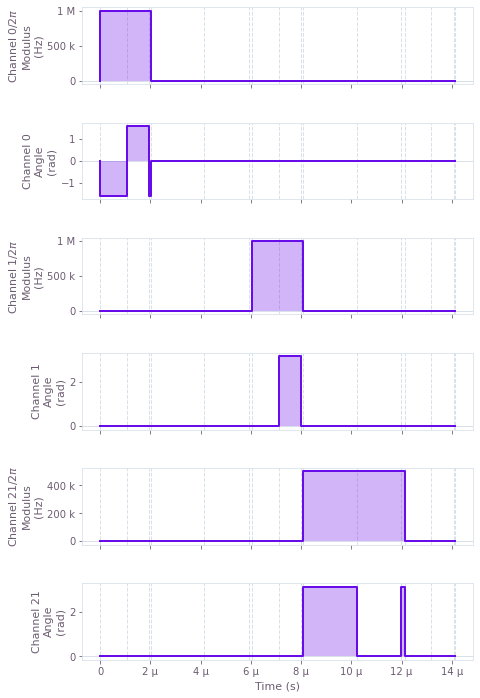

In [4]:
pulse_dictionary = {
    "Channel 0": [{"duration": d, "value": v} for d, v in zip(durations, channel_0)],
    "Channel 1": [{"duration": d, "value": v} for d, v in zip(durations, channel_1)],
    "Channel 21": [{"duration": d, "value": v} for d, v in zip(durations, channel_21)],
}
fig = plt.figure()
plot_controls(fig, pulse_dictionary)
plt.show()

### Setting up the simulation graph 

To simulate the dynamics of this multi-qubit quantum circuit with the Q-CTRL Python package, we start by setting up a graph object as described in the [Set up quantum systems](https://docs.q-ctrl.com/boulder-opal/user-guides/set-up-quantum-systems) user guide. After setting up the piecewise-constant (PWC) Hamiltonian of the system, we create a simulation node using the  [`qctrl.operations.time_evolution_operators_pwc`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/time_evolution_operators_pwc.html) function and request samples at `sample_times` points. 

We can also use [`qctrl.operations.density_matrix_evolution_pwc`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/density_matrix_evolution_pwc.html) to simulate an open system evolution as outlined in the [Simulate open system dynamics](https://docs.q-ctrl.com/boulder-opal/user-guides/simulate-open-system-dynamics) user guide.

In [5]:
sample_times = np.linspace(0, np.sum(durations), 100)

# Create the QCTRL Graph session
with qctrl.create_graph() as graph:
    # Define the controls on the five channels
    signal_0 = qctrl.operations.tensor_pwc(
        durations=durations, values=channel_0, name="ch0"
    )
    signal_1 = qctrl.operations.tensor_pwc(
        durations=durations, values=channel_1, name="ch1"
    )
    signal_2 = qctrl.operations.tensor_pwc(
        durations=durations, values=channel_2, name="ch2"
    )
    signal_10 = qctrl.operations.tensor_pwc(
        durations=durations, values=channel_10, name="ch10"
    )
    signal_21 = qctrl.operations.tensor_pwc(
        durations=durations, values=channel_21, name="ch21"
    )

    # Next, define the various local Hamiltonian terms
    term_0 = qctrl.operations.pwc_operator(
        signal=signal_0, operator=kron(sigma_m, identity, identity)
    )
    term_1 = qctrl.operations.pwc_operator(
        signal=signal_1, operator=kron(identity, sigma_m, identity)
    )
    term_2 = qctrl.operations.pwc_operator(
        signal=signal_2, operator=kron(identity, identity, sigma_m)
    )
    term_10 = qctrl.operations.pwc_operator(
        signal=signal_10, operator=kron(sigma_z, sigma_m, identity)
    )
    term_21 = qctrl.operations.pwc_operator(
        signal=signal_21, operator=kron(identity, sigma_z, sigma_m)
    )

    # Combine the terms to obtain the system Hamiltonian.
    system_hamiltonian = qctrl.operations.pwc_sum(
        [
            qctrl.operations.pwc_operator_hermitian_part(operator=term_0),
            qctrl.operations.pwc_operator_hermitian_part(operator=term_1),
            qctrl.operations.pwc_operator_hermitian_part(operator=term_2),
            qctrl.operations.pwc_operator_hermitian_part(operator=term_10),
            qctrl.operations.pwc_operator_hermitian_part(operator=term_21),
        ],
        name="System Hamiltonian",
    )

    # Compute the unitary using `time_evolution_operators_pwc`
    unitaries = qctrl.operations.time_evolution_operators_pwc(
        hamiltonian=system_hamiltonian,
        sample_times=sample_times,
        name="unitaries",
    )

    # Evolve the initial state with the unitary to get the final state
    final_states = qctrl.operations.matmul(
        unitaries, initial_state, name="final_states"
    )

# Run simulation.
results = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=["unitaries", "final_states"],
)

Your task calculate_graph has completed in 3s.


### Plotting the system evolution

Let us visualize the trajectory of the system as gates are applied to the initial state. We see that the entire population starts in the ground state and the population of the ground state $|000\rangle$ and the highest excited state $|111\rangle$ equalizes as expected towards the end of the evolution.

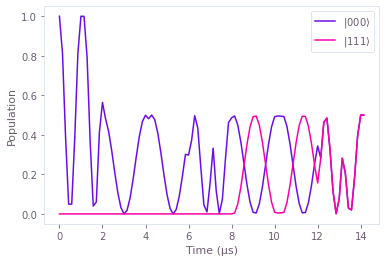

In [6]:
final_states = results.output["final_states"]["value"]
population = np.squeeze(np.real_if_close(final_states * final_states.conj()))

plt.plot(np.linspace(0, np.sum(durations), 100) * 1e6, population[:, [0, -1]])
plt.xlabel("Time (\N{MICRO SIGN}s)")
plt.ylabel("Population")
plt.legend([r"$|000\rangle$", r"$|111\rangle$"])
plt.show()

### Simulation under dephasing noise 

Building on this example, suppose there is also a dephasing noise on the single qubit channel:
$$
H^{\rm{S}}_{i}(t) = \frac{1}{2} \Omega_{i}(t) \sigma^{-}_{i} + \frac{1}{2} \Omega_{i}^{*}(t)\sigma^{+}_{i} + \frac{\eta(t)}{2} \sigma^z_i
$$
where $\eta(t)$ is a random variable with a power spectrum that can be described by the pink ($1/f$) noise model shown below.

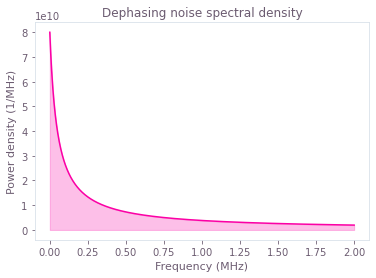

In [7]:
def pink_spectrum(frequencies, frequency_cutoff):
    return 1 / (frequencies + frequency_cutoff)


frequencies = np.arange(0, 2 * 1e6, 2 * 1e3)

power_densities = 4e9 * pink_spectrum(
    frequencies=frequencies, frequency_cutoff=0.05 * 1e6
)

plt.plot(frequencies / 1e6, power_densities * 1e6, c="#FB00A5")
plt.fill_between(
    frequencies / 1e6, 0, power_densities * 1e6, alpha=0.25, color="#FB00A5"
)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power density (1/MHz)")
plt.title("Dephasing noise spectral density")
plt.show()

Since the noise process is random, we need to run many simulations of the circuit with the noise to get a correct estimate of the system evolution. In each simulation run, we sample the power spectrum of the noise to obtain time-ordered trajectories for the noise variable $\eta(t)$ and add then add them to appropriate single qubit channels. We then average out the finals states to obtain the density matrix representing the noisy evolution.

Here, we will use pre-generated noise trajectories for simulations and use the batching feature to run multiple simulations with just one call to the `qctrl.functions.calculate_graph` function. See the [`qctrl.operations.pwc_signal`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/pwc_signal.html) function to learn more about batches in the Q-CTRL simulation engine.

In [8]:
def load_var(file_name):
    # Return a variable from a json file
    f = open(file_name, "r+")
    encoded = f.read()
    decoded = jsonpickle.decode(encoded)
    f.close()
    return decoded


# We use a file containing pre-generated noise trajectories.
# You can access this file at https://app.q-ctrl.com, or you can use your own trajectories.
noise_trajectories = load_var("resources/simulate-multi-qubit-circuits/trajectories")
trajectory_count = len(noise_trajectories)

noise_trajectories = np.array(noise_trajectories)

Next, we run circuit simulations in a batch and average out the state vector obtained from each run. In each batch, we choose noise trajectories at random to simulate the effect of the $1/f$ noise. These noise trajectories were sampled on $50$ time points between the start and end of the circuit whereas the GHZ schedule has been defined over $15$ time segments. The Q-CTRL Python package automatically reconciles differing time segmentation while summing over  Hamiltonian terms.

In [9]:
def repeat_signal(signal, batch_count):
    # Copies a 1-D signal to multiple rows. Input 1xN, output batch_countxN
    return np.repeat(np.expand_dims(signal, axis=0), batch_count, axis=0)


def random_noise_signal(batch_count):
    # Return `batch_count` number of randomly chosen noise trajectories
    return noise_trajectories[random_sample(range(trajectory_count), k=batch_count), :]


def get_computation_graph(batch_count):
    # Create a graph for the GHZ circuit with noise trajectories.
    with qctrl.create_graph() as graph:
        # Define the controls on the five channels
        signal_0 = qctrl.operations.tensor_pwc(
            durations=durations,
            values=repeat_signal(channel_0, batch_count),
            time_dimension=1,
        )
        signal_1 = qctrl.operations.tensor_pwc(
            durations=durations,
            values=repeat_signal(channel_1, batch_count),
            time_dimension=1,
        )
        signal_2 = qctrl.operations.tensor_pwc(
            durations=durations,
            values=repeat_signal(channel_2, batch_count),
            time_dimension=1,
        )
        signal_10 = qctrl.operations.tensor_pwc(
            durations=durations,
            values=repeat_signal(channel_10, batch_count),
            time_dimension=1,
        )
        signal_21 = qctrl.operations.tensor_pwc(
            durations=durations,
            values=repeat_signal(channel_21, batch_count),
            time_dimension=1,
        )

        # System Hamiltonian
        term_0 = qctrl.operations.pwc_operator(
            signal=signal_0, operator=kron(sigma_m, identity, identity)
        )
        term_1 = qctrl.operations.pwc_operator(
            signal=signal_1, operator=kron(identity, sigma_m, identity)
        )
        term_2 = qctrl.operations.pwc_operator(
            signal=signal_2, operator=kron(identity, identity, sigma_m)
        )
        term_10 = qctrl.operations.pwc_operator(
            signal=signal_10, operator=kron(sigma_z, sigma_m, identity)
        )
        term_21 = qctrl.operations.pwc_operator(
            signal=signal_21, operator=kron(identity, sigma_z, sigma_m)
        )

        system_hamiltonian = qctrl.operations.pwc_sum(
            [
                qctrl.operations.pwc_operator_hermitian_part(operator=term_0),
                qctrl.operations.pwc_operator_hermitian_part(operator=term_1),
                qctrl.operations.pwc_operator_hermitian_part(operator=term_2),
                qctrl.operations.pwc_operator_hermitian_part(operator=term_10),
                qctrl.operations.pwc_operator_hermitian_part(operator=term_21),
            ]
        )

        # Noise Hamiltonian. signal_pwc accepts uniformly spaced points.
        noise_ch0 = qctrl.operations.pwc_signal(
            duration=np.sum(durations),
            values=random_noise_signal(batch_count),
        )
        noise_ch1 = qctrl.operations.pwc_signal(
            duration=np.sum(durations),
            values=random_noise_signal(batch_count),
        )
        noise_ch2 = qctrl.operations.pwc_signal(
            duration=np.sum(durations),
            values=random_noise_signal(batch_count),
        )

        noise_hamiltonian = qctrl.operations.pwc_sum(
            [
                qctrl.operations.pwc_operator(
                    signal=noise_ch0, operator=kron(sigma_z, identity, identity)
                ),
                qctrl.operations.pwc_operator(
                    signal=noise_ch1, operator=kron(identity, sigma_z, identity)
                ),
                qctrl.operations.pwc_operator(
                    signal=noise_ch2, operator=kron(identity, identity, sigma_z)
                ),
            ]
        )

        # Combine the system and the noise Hamiltonian to get the total Hamiltonian.
        hamiltonian = qctrl.operations.pwc_sum(
            [system_hamiltonian, noise_hamiltonian],
            name="Hamiltonian",
        )

        # Compute the unitary using `time_evolution_operators_pwc`
        unitaries = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=sample_times,
            name="unitaries",
        )

        # Use the unitary to evolve the initial state into the final state
        final_states = qctrl.operations.matmul(
            unitaries, initial_state, name="final_states"
        )

    return graph

In [10]:
# Run simulation.
results = qctrl.functions.calculate_graph(
    graph=get_computation_graph(batch_count=20),
    output_node_names=["unitaries", "final_states"],
)

final_states = results.output["final_states"]["value"]

Your task calculate_graph has completed in 5s.


After the simulation is successfully completed, we obtain the trajectories of the system in the variable `final_states`. The first dimension of the `final_states` is of length `batch_count`, the second dimension accounts for the time points sampled from the evolution, and the last two dimensions contain the state vector at each of the time point. 

We can average out these trajectories to obtain the approximate density matrix of the system and plot the population in the $|000\rangle$ and the $|111\rangle$ states.

In [11]:
def get_density_matrix(final_states):
    # Average out the final states to get the density matrix, ρ = average(|ψ><ψ|)
    density_matrix = np.average(
        final_states * final_states.conj().swapaxes(-1, -2), axis=0
    )
    return density_matrix


density_matrix = get_density_matrix(final_states)
noise_population = np.real_if_close(np.diagonal(density_matrix, axis1=-1, axis2=-2))

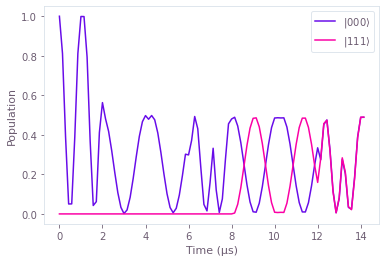

In [12]:
plt.plot(np.linspace(0, np.sum(durations), 100) * 1e6, noise_population[:, [0, -1]])
plt.xlabel("Time (\N{MICRO SIGN}s)")
plt.ylabel("Population")
plt.legend([r"$|000\rangle$", r"$|111\rangle$"])
plt.show()

This evolution looks very similar to the noiseless case. The impact of the noise is visible in the difference between the ideal population and the population under noisy evolution. The ideal states lose about $2\%$ of population each.

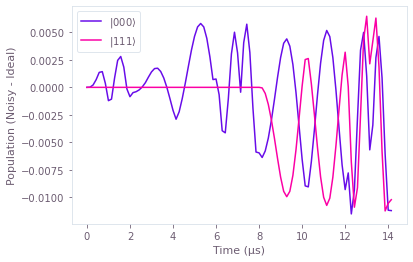

In [13]:
population_difference = noise_population - population
plt.plot(
    np.linspace(0, np.sum(durations), 100) * 1e6, population_difference[:, [0, -1]]
)
plt.xlabel("Time (\N{MICRO SIGN}s)")
plt.ylabel("Population (Noisy - Ideal)")
plt.legend([r"$|000\rangle$", r"$|111\rangle$"])
plt.show()

### Summary

We have shown how the Q-CTRL Python package can simulate quantum dynamics of a multi-qubit circuit with and without presence of noise. While we have considered the cross-resonance Hamiltonian model here, the basic principles remain the same for any kind of Hamiltonian model. To simulate any circuit, we need to convert the gates in the circuit to corresponding pulses that implement those gates using the underlying Hamiltonian. The resultant set of pulses form a schedule which can be then simulated using the Q-CTRL Python package. We manually specified the schedule in this notebook but it can be also generated automatically using a software called scheduler, such as [one provided in Qiskit](https://web.archive.org/web/20210121202030/https://qiskit.org/documentation/stubs/qiskit.compiler.schedule.html).